# 05. Transfer Learning with TensorFlow Part 2: Fine-tuning


## Warming

In [ ]:
import tensorflow as tf

print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.19.0


In [ ]:
# Are we using a GPU ?
!nvidia-smi

Mon Sep 15 11:55:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Creating Helper Functions

Throughout your machine learning expriments, you'll likely come across snippets of code you want to over and over again.

In [5]:
# Get helper_functions.py script
!wget https://raw.githubusercontent.com/MahdadGhasemian/ai-lab/main/tensorflow-deep-learning/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2025-09-15 12:13:25--  https://raw.githubusercontent.com/MahdadGhasemian/ai-lab/main/tensorflow-deep-learning/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10836 (11K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.58K  --.-KB/s    in 0s      

2025-09-15 12:13:25 (134 MB/s) - ‘helper_functions.py’ saved [10836/10836]



## 10 Food Classes: Working with less data

In [6]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2025-09-15 12:16:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 64.233.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.4MB/s    in 8.1s    

2025-09-15 12:16:37 (19.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



The dataset we're downloading is the 10 food classes dataset (from Food 101) with 10% of the training images we used in the previous notebook.

In [7]:
# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/trai

Let's define our training and test filepaths.

In [8]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [9]:
# Create data inputs
import tensorflow as tf

IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [10]:
# Check the training data datatype
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In the above output:

* `(None, 224, 224, 3)` refers to the tensor shape of our images where `None` is the batch size, `224` is the height (and width) and 3 is the color channels (red, green, blue).
* `(None, 10)` refers to the tensor shape of the labels where `None` is the batch size and `10` is the number of possible labels (the 10 different food classes).
* Both image tensors and labels are of the datatype `tf.float32`.

The `batch_size` is `None` due to it only being used during model training. You can think of `None` as a placeholder waiting to be filled with the `batch_size` parameter from `image_dataset_from_directory()`.

Another benefit of using the `tf.data.Dataset` API is the associated methods which come with it.

For example, if we want to find the name of the classes we were working with, we could use the `class_names` attribute.

In [11]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

Or if we wanted to see an example batch of data, we could use the `take()` method.

In [13]:
# See an example batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.54698975e+02 1.26698982e+02 1.12698982e+02]
   [1.49056122e+02 1.21295921e+02 1.05505104e+02]
   [1.36561218e+02 1.07698982e+02 8.92857132e+01]
   ...
   [1.31872498e+02 7.80867538e+01 7.56582260e+01]
   [1.30841873e+02 7.98418732e+01 7.68418732e+01]
   [1.25509903e+02 7.45099030e+01 7.35099030e+01]]

  [[1.91367355e+02 1.67158157e+02 1.50367355e+02]
   [1.89989792e+02 1.66576523e+02 1.48714279e+02]
   [1.90765320e+02 1.65622467e+02 1.45265320e+02]
   ...
   [1.23612244e+02 6.79387589e+01 6.64541016e+01]
   [1.13709129e+02 5.97091255e+01 5.77091255e+01]
   [1.01372223e+02 4.73722267e+01 4.73722267e+01]]

  [[2.08413269e+02 1.89846939e+02 1.67561234e+02]
   [2.09076538e+02 1.91306122e+02 1.68734695e+02]
   [2.12755112e+02 1.92397964e+02 1.70846939e+02]
   ...
   [1.02964317e+02 4.45357475e+01 4.35816841e+01]
   [1.04311287e+02 4.52807045e+01 4.72245712e+01]
   [1.20566528e+02 6.22706985e+01 6.39900589e+01]]

  ...

  [[2.23433777e+02 2.06862305e+02 1.88648041e+02]
   [2

### Model 0: Building a transfer learning model using the Keras Functional API


In [16]:
# 1. Create base model with tf.keras.applicatins
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False) # we do this because we're going to create our own top, which are the output layers for the model

# 2. Freese the base model (so the pre-learned patterns remain)
base_model.trainable = False # to freeze all of the weights in the pre-trained model

# 3. Create input into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20250915-131015
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.3388 - loss: 2.0094 - val_accuracy: 0.7862 - val_loss: 1.2357
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.7682 - loss: 1.1769 - val_accuracy: 0.8520 - val_loss: 0.8439
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - accuracy: 0.8309 - loss: 0.8324 - val_accuracy: 0.8618 - val_loss: 0.6674
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.8648 - loss: 0.6607 - val_accuracy: 0.8684 - val_loss: 0.5980
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.8806 - loss: 0.5629 - val_accuracy: 0.8882 - val_loss: 0.5258


It's important to note the kind of transfer learning we used here is called feature extraction transfer learning, similar to what we did with the TensorFlow Hub models.

In other words, we passed our custom data to an already pre-trained model (`EfficientNetV2B0`), asked it "what patterns do you see?" and then put our own output layer on top to make sure the outputs were tailored to our desired number of classes.

We also used the Keras Functional API to build our model rather than the Sequential API. For now, the benefits of this main not seem clear but when you start to build more sophisticated models, you'll probably want to use the Functional API. So it's important to have exposure to this way of building models.

Let's inspect the layers in our model, we'll start with the base.

In [17]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_layer_2
1 rescaling_2
2 normalization_2
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_con

Wow, that's a lot of layers... to handcode all of those would've taken a fairly long time to do, yet we can still take advatange of them thanks to the power of transfer learning.

How about a summary of the base model?

In [18]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, None,      │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, None,      │          0 │ rescaling_2[0][0] │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ normalization_2[… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1a_project_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, None,      │     36,864 │ block2a_project_… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, None,      │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, None,      │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

You can see how each of the different layers have a certain number of parameters each. Since we are using a pre-trained model, you can think of all of these parameters are patterns the base model has learned on another dataset. And because we set `base_model.trainable = False`, these patterns remain as they are during training (they're frozen and don't get updated).

Alright that was the base model, let's see the summary of our overall model.

In [19]:
# Cehck summary of model constructed with Functional API
model_0.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

How do our model's training curves look?

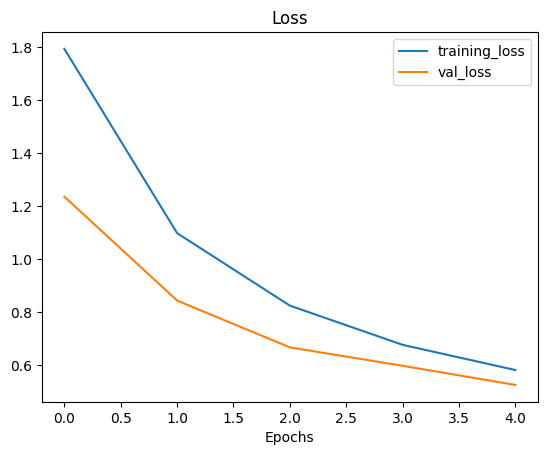

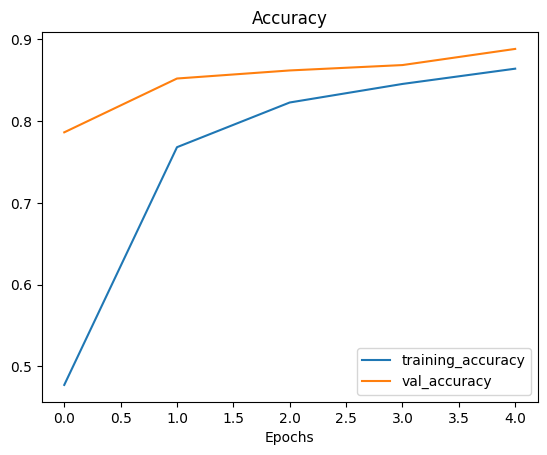

In [20]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

What is the `tf.keras.layers.GlobalAveragePooling2D()` ?

In [ ]:
# Define input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")